In [1]:
import re
import tensorflow as tf
import numpy as np

from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
filename = 'data/raw_text/aesop_fable.txt'

with open(filename, 'r', encoding='utf-8-sig') as f:
    raw_text = f.read()

In [4]:
print(raw_text[:10])

The Wolf A


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
file_name = "data/GloVe/glove.6B.50d.txt"

embedding = {}
idx_to_word = {}
word_to_idx = {}
bad_lines = 0

with open(file_name, 'r', encoding='UTF-8') as f:
    for idx, line in enumerate(f):
        try:
            line = line.strip()
            match_obj = re.match(r'([^\s]+)', line)
            word = match_obj.group(1)
            word_len = len(word)
            word_vec = line[word_len:].replace('\n', '')

            embed = word_vec.strip()
            embed = embed.split()
            embed = np.array(embed, dtype=np.float32)
            
            embedding[idx] = [embed]
            idx_to_word[idx] = word.strip()
            word_to_idx[word.strip()] = idx
        except:
            bad_lines += 1

print(f'Bad lines: {bad_lines}')

Bad lines: 0


In [7]:
w1 = 'waiter'
w2 = 'waitress'

w1_embed = embedding[word_to_idx[w1]]
w2_embed = embedding[word_to_idx[w2]]
cosine_similarity(w1_embed, w2_embed)

array([[0.8778121]], dtype=float32)

In [8]:
def get_embedding(word):
    if word in word_to_idx:
        return embedding[word_to_idx[word]]
    else:
        return embedding[word_to_idx['umm']]

In [9]:
def generate_sequences(text, seq_length):
    tokens = tokenizer.tokenize(text)
    num_sequences = len(tokens) - seq_length
    
    x = []
    x_token = np.zeros((num_sequences, seq_length+2))
    x_mask = np.zeros((num_sequences, seq_length+2))
    y_token = np.zeros((num_sequences, 50), dtype=np.float32)

    for i in range(0, num_sequences):
        seq = tokens[i:i + seq_length]
        input = tokenizer.encode_plus(seq, max_length=seq_length+2, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
        
        x.append(seq)
        x_token[i, :] = input['input_ids']
        x_mask[i, :] = input['attention_mask']
        y_token[i, :] = get_embedding(tokens[i + seq_length])[0]

    print(f'Number of sequences: {num_sequences}')

    return x, x_token, x_mask, y_token, num_sequences

seq_length = 20
x, x_token, x_mask, y_token, num_sequences = generate_sequences(raw_text, seq_length)

2021-11-16 14:02:45.823900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 14:02:45.828886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 14:02:45.829223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 14:02:45.829882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Number of sequences: 55180


In [10]:
print(x[:2])
print(x_token[:2])
print(x_mask[:2])
print(y_token[:2])

[['the', 'wolf', 'and', 'the', 'lamb', 'wolf', ',', 'meeting', 'with', 'a', 'lamb', 'as', '##tray', 'from', 'the', 'fold', ',', 'resolved', 'not', 'to'], ['wolf', 'and', 'the', 'lamb', 'wolf', ',', 'meeting', 'with', 'a', 'lamb', 'as', '##tray', 'from', 'the', 'fold', ',', 'resolved', 'not', 'to', 'lay']]
[[  101.  1996.  4702.  1998.  1996. 12559.  4702.  1010.  3116.  2007.
   1037. 12559.  2004. 28473.  2013.  1996. 10671.  1010. 10395.  2025.
   2000.   102.]
 [  101.  4702.  1998.  1996. 12559.  4702.  1010.  3116.  2007.  1037.
  12559.  2004. 28473.  2013.  1996. 10671.  1010. 10395.  2025.  2000.
   3913.   102.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[ 1.1417e+00  4.6283e-01  3.1850e-01 -1.0938e+00  7.7268e-01 -8.5313e-03
  -2.7627e-01  1.9700e-01  2.5137e-01 -7.4092e-01 -5.2680e-01  6.7512e-02
  -6.1951e-01  3.2295e-01 -2.9231e-01  2.7597e-01 -2.1011e-02 -4.3145e-01
   8.1964

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((x_token, x_mask, y_token))
dataset.take(1)

<TakeDataset shapes: ((22,), (22,), (50,)), types: (tf.float64, tf.float64, tf.float32)>

In [12]:
def combine_input_mask(input_id, mask, y_token):
    return {'input_ids': input_id, 'attention_mask': mask}, y_token

dataset = dataset.map(combine_input_mask)
dataset.take(1)


<TakeDataset shapes: ({input_ids: (22,), attention_mask: (22,)}, (50,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [13]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (32, 22), attention_mask: (32, 22)}, (32, 50)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float32)>

In [14]:
split = 0.8
sample_size = int((num_sequences // batch_size) * split)

ds_train = dataset.take(sample_size)
ds_test = dataset.skip(sample_size)

In [15]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

2021-11-16 14:03:02.514477: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further tr

In [16]:
# supress INFO and Warning messages https://github.com/tensorflow/tensorflow/issues/47554
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model', monitor='val_loss',
                     mode='min', save_best_only=True, verbose=1, save_format='tf')

input_layer = Input(shape=(seq_length+2,), name='input_ids', dtype=tf.int32)
mask_layer = Input(shape=(seq_length+2,),
                   name='attention_mask', dtype=tf.int32)

embedding_layer = bert.bert(input_layer, attention_mask=mask_layer)[1]

out = Dense(1024, activation='relu')(embedding_layer)
out = Dropout(0.2)(out)
out = Dense(50)(out)

model = Model(inputs=[input_layer, mask_layer], outputs=out)

model.layers[2].trainable = False

optimizer = SGD(learning_rate=0.00009, decay=1e-6)
model.compile(optimizer=optimizer,
              loss=tf.losses.mean_squared_error, metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_test,
                    batch_size=64, epochs=100, shuffle=True, verbose=1, callbacks=[es, mc])


Epoch 1/100
1379/1379 [==============================] - ETA: 0s - loss: 0.4963 - accuracy: 0.5139
Epoch 00001: val_loss improved from inf to 0.34381, saving model to best_model


2021-11-16 14:04:33.511842: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 77s 54ms/step - loss: 0.4963 - accuracy: 0.5139 - val_loss: 0.3438 - val_accuracy: 0.7881
Epoch 2/100
   1/1379 [..............................] - ETA: 1:26 - loss: 0.3399 - accuracy: 0.8438

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.8165
Epoch 00002: val_loss improved from 0.34381 to 0.31698, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 74s 54ms/step - loss: 0.3634 - accuracy: 0.8165 - val_loss: 0.3170 - val_accuracy: 0.7987
Epoch 3/100
   1/1379 [..............................] - ETA: 1:29 - loss: 0.2729 - accuracy: 0.9688

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.8264
Epoch 00003: val_loss improved from 0.31698 to 0.31689, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 74s 54ms/step - loss: 0.3448 - accuracy: 0.8264 - val_loss: 0.3169 - val_accuracy: 0.7972
Epoch 4/100
   1/1379 [..............................] - ETA: 1:45 - loss: 0.3509 - accuracy: 0.7812

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3374 - accuracy: 0.8303
Epoch 00004: val_loss improved from 0.31689 to 0.31232, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 74s 54ms/step - loss: 0.3374 - accuracy: 0.8303 - val_loss: 0.3123 - val_accuracy: 0.8002
Epoch 5/100
   1/1379 [..............................] - ETA: 1:27 - loss: 0.3233 - accuracy: 0.8750

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8315
Epoch 00005: val_loss improved from 0.31232 to 0.31010, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 69s 50ms/step - loss: 0.3321 - accuracy: 0.8315 - val_loss: 0.3101 - val_accuracy: 0.7992
Epoch 6/100
   1/1379 [..............................] - ETA: 1:33 - loss: 0.3029 - accuracy: 0.9375

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.8340
Epoch 00006: val_loss improved from 0.31010 to 0.30667, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 66s 48ms/step - loss: 0.3273 - accuracy: 0.8340 - val_loss: 0.3067 - val_accuracy: 0.8044
Epoch 7/100
   1/1379 [..............................] - ETA: 1:33 - loss: 0.3477 - accuracy: 0.7812

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8341
Epoch 00007: val_loss improved from 0.30667 to 0.30488, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 66s 48ms/step - loss: 0.3232 - accuracy: 0.8341 - val_loss: 0.3049 - val_accuracy: 0.8051
Epoch 8/100
   1/1379 [..............................] - ETA: 1:30 - loss: 0.3149 - accuracy: 0.8125

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8363
Epoch 00008: val_loss improved from 0.30488 to 0.30339, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 68s 49ms/step - loss: 0.3187 - accuracy: 0.8363 - val_loss: 0.3034 - val_accuracy: 0.8023
Epoch 9/100
   1/1379 [..............................] - ETA: 1:23 - loss: 0.2964 - accuracy: 0.8438

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3158 - accuracy: 0.8379
Epoch 00009: val_loss did not improve from 0.30339
1379/1379 [==============================] - 52s 38ms/step - loss: 0.3158 - accuracy: 0.8379 - val_loss: 0.3052 - val_accuracy: 0.8026
Epoch 10/100
1379/1379 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8370
Epoch 00010: val_loss did not improve from 0.30339
1379/1379 [==============================] - 53s 38ms/step - loss: 0.3135 - accuracy: 0.8370 - val_loss: 0.3036 - val_accuracy: 0.8037
Epoch 11/100
1378/1379 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8370
Epoch 00011: val_loss improved from 0.30339 to 0.30247, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 69s 50ms/step - loss: 0.3102 - accuracy: 0.8370 - val_loss: 0.3025 - val_accuracy: 0.8044
Epoch 12/100
   1/1379 [..............................] - ETA: 1:24 - loss: 0.2821 - accuracy: 0.9062

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.8373
Epoch 00012: val_loss did not improve from 0.30247
1379/1379 [==============================] - 53s 38ms/step - loss: 0.3087 - accuracy: 0.8373 - val_loss: 0.3034 - val_accuracy: 0.8005
Epoch 13/100
1379/1379 [==============================] - ETA: 0s - loss: 0.3057 - accuracy: 0.8382
Epoch 00013: val_loss improved from 0.30247 to 0.30003, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 68s 49ms/step - loss: 0.3057 - accuracy: 0.8382 - val_loss: 0.3000 - val_accuracy: 0.8053
Epoch 14/100
   1/1379 [..............................] - ETA: 1:35 - loss: 0.2962 - accuracy: 0.8125

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8393
Epoch 00014: val_loss improved from 0.30003 to 0.29970, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 67s 49ms/step - loss: 0.3033 - accuracy: 0.8393 - val_loss: 0.2997 - val_accuracy: 0.8062
Epoch 15/100
   1/1379 [..............................] - ETA: 1:26 - loss: 0.2475 - accuracy: 0.9375

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8379
Epoch 00015: val_loss did not improve from 0.29970
1379/1379 [==============================] - 55s 40ms/step - loss: 0.3019 - accuracy: 0.8379 - val_loss: 0.3000 - val_accuracy: 0.7999
Epoch 16/100
1379/1379 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8374
Epoch 00016: val_loss improved from 0.29970 to 0.29784, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 67s 49ms/step - loss: 0.3005 - accuracy: 0.8374 - val_loss: 0.2978 - val_accuracy: 0.8034
Epoch 17/100
   1/1379 [..............................] - ETA: 1:38 - loss: 0.3627 - accuracy: 0.7500

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8385
Epoch 00017: val_loss did not improve from 0.29784
1379/1379 [==============================] - 55s 40ms/step - loss: 0.2983 - accuracy: 0.8385 - val_loss: 0.2998 - val_accuracy: 0.8000
Epoch 18/100
1379/1379 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.8388
Epoch 00018: val_loss improved from 0.29784 to 0.29746, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 68s 49ms/step - loss: 0.2967 - accuracy: 0.8388 - val_loss: 0.2975 - val_accuracy: 0.8064
Epoch 19/100
   1/1379 [..............................] - ETA: 1:25 - loss: 0.2744 - accuracy: 0.9062

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8391
Epoch 00019: val_loss improved from 0.29746 to 0.29682, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 67s 49ms/step - loss: 0.2952 - accuracy: 0.8391 - val_loss: 0.2968 - val_accuracy: 0.8066
Epoch 20/100
   1/1379 [..............................] - ETA: 1:29 - loss: 0.3362 - accuracy: 0.6875

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.2939 - accuracy: 0.8386
Epoch 00020: val_loss improved from 0.29682 to 0.29620, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 67s 48ms/step - loss: 0.2939 - accuracy: 0.8386 - val_loss: 0.2962 - val_accuracy: 0.8067
Epoch 21/100
   1/1379 [..............................] - ETA: 1:34 - loss: 0.2808 - accuracy: 0.9375

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.8384
Epoch 00021: val_loss did not improve from 0.29620
1379/1379 [==============================] - 52s 38ms/step - loss: 0.2924 - accuracy: 0.8384 - val_loss: 0.2977 - val_accuracy: 0.8042
Epoch 22/100
1379/1379 [==============================] - ETA: 0s - loss: 0.2915 - accuracy: 0.8379
Epoch 00022: val_loss did not improve from 0.29620
1379/1379 [==============================] - 52s 38ms/step - loss: 0.2915 - accuracy: 0.8379 - val_loss: 0.2984 - val_accuracy: 0.8019
Epoch 23/100
1379/1379 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.8387
Epoch 00023: val_loss did not improve from 0.29620
1379/1379 [==============================] - 53s 38ms/step - loss: 0.2901 - accuracy: 0.8387 - val_loss: 0.2983 - val_accuracy: 0.8022
Epoch 24/100
1379/1379 [==============================] - ETA: 0s - loss: 0.2898 - accuracy: 0.8380
Epoch 00024: val_loss improved from 0.29620 to 0.29448,

INFO:tensorflow:Assets written to: best_model/assets


1379/1379 [==============================] - 68s 49ms/step - loss: 0.2898 - accuracy: 0.8380 - val_loss: 0.2945 - val_accuracy: 0.8079
Epoch 25/100
   1/1379 [..............................] - ETA: 1:26 - loss: 0.2912 - accuracy: 0.8438

/usr/local/python/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


1379/1379 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8385
Epoch 00025: val_loss did not improve from 0.29448
1379/1379 [==============================] - 52s 38ms/step - loss: 0.2881 - accuracy: 0.8385 - val_loss: 0.2967 - val_accuracy: 0.8061
Epoch 26/100
1379/1379 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8375
Epoch 00026: val_loss did not improve from 0.29448
1379/1379 [==============================] - 53s 38ms/step - loss: 0.2875 - accuracy: 0.8375 - val_loss: 0.2974 - val_accuracy: 0.8045
Epoch 27/100
1379/1379 [==============================] - ETA: 0s - loss: 0.2859 - accuracy: 0.8384
Epoch 00027: val_loss did not improve from 0.29448
1379/1379 [==============================] - 53s 39ms/step - loss: 0.2859 - accuracy: 0.8384 - val_loss: 0.2967 - val_accuracy: 0.8012
Epoch 28/100
1379/1379 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8371
Epoch 00028: val_loss did not improve from 0.29448
1379

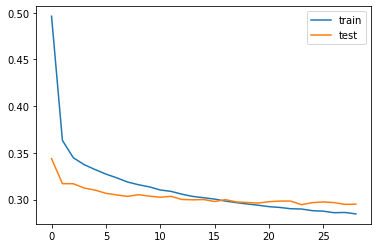

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()